In [30]:
import sys
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import zscore
import pandas as pd
from sqlalchemy import create_engine
import psycopg2
sys.path.append(os.path.abspath('../scripts'))

In [9]:
from load_data import load_data_from_postgres, load_data_using_sqlalchemy
from utils import missing_values_table, convert_bytes_to_megabytes, outliers_table, fix_outlier

In [9]:


def load_data_from_postgres(query, db_params):
    """
    Load data from a PostgreSQL database into a pandas DataFrame.

    Parameters:
    - query: SQL query string to execute.
    - db_params: Dictionary containing database connection parameters.

    Returns:
    - DataFrame containing the query results.
    """
    try:
        # Create a connection string
        conn_str = f"postgresql://{db_params['user']}:{db_params['password']}@{db_params['host']}:{db_params['port']}/{db_params['dbname']}"
        
        # Create an SQLAlchemy engine
        engine = create_engine(conn_str)

        # Load data into DataFrame
        df = pd.read_sql(query, engine)
        return df

    except Exception as e:
        print(f"An error occurred: {e}")
        return None


In [59]:
def missing_values_table(df):
    # Total missing values
    mis_val = df.isnull().sum()

    # Percentage of missing values
    mis_val_percent = 100 * df.isnull().sum() / len(df)

    # dtype of missing values
    mis_val_dtype = df.dtypes

    # Make a table with the results
    mis_val_table = pd.concat([mis_val, mis_val_percent, mis_val_dtype], axis=1)

    # Rename the columns
    mis_val_table_ren_columns = mis_val_table.rename(
        columns={0: 'Missing Values', 1: '% of Total Values', 2: 'Dtype'})

    # Sort the table by percentage of missing descending
    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns['% of Total Values'] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)

    # Print some summary information
    print("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"
          "There are " + str(mis_val_table_ren_columns.shape[0]) +
          " columns that have missing values.")

    # Return the dataframe with missing information
    return mis_val_table_ren_columns



def outliers_table(df):
    # Initialize empty lists to store results
    outliers_info = []
    
    # Iterate through numerical columns
    for col in df.select_dtypes(include=['float64', 'int64']).columns:
        # Calculate Z-scores
        z_scores = np.abs(zscore(df[col].dropna()))
        
        # Calculate IQR
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        
        # Z-score method
        z_score_outliers = (z_scores > 3).sum()
        
        # IQR method
        iqr_outliers = ((df[col] < (Q1 - 1.5 * IQR)) | (df[col] > (Q3 + 1.5 * IQR))).sum()
        
        # Append results
        outliers_info.append({
            'Column': col,
            'Z-Score Outliers': z_score_outliers,
            'IQR Outliers': iqr_outliers
        })
    
    # Convert results to DataFrame
    outliers_table_df = pd.DataFrame(outliers_info)
    
    # Print some summary information
    print("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"
          "Outlier information for numerical columns is displayed below.")
    
    # Return the dataframe with outlier information
    return outliers_table_df


def convert_bytes_to_megabytes(df, bytes_data):
    megabyte = 1e+6  # 1 MB = 1e+6 Bytes
    df[bytes_data] = df[bytes_data] / megabyte
    return df[bytes_data]


def convert_ms_to_seconds(ms):
    return ms / 1000



def fix_outlier(df, column, percentile=0.95):
    threshold = df[column].quantile(percentile)
    median = df[column].median()
    df[column] = np.where(df[column] > threshold, median, df[column])
    return df[column]


def remove_outliers(df, column_to_process, z_threshold=3):
    # Apply outlier removal to the specified column
    df = df.copy()  # Avoid modifying the original DataFrame
    z_scores = zscore(df[column_to_process].dropna())
    df['z_score'] = np.nan
    df.loc[df[column_to_process].notna(), 'z_score'] = z_scores

    outlier_column = column_to_process + '_Outlier'
    df[outlier_column] = (np.abs(df['z_score']) > z_threshold).astype(int)
    df = df[df[outlier_column] == 0]  # Keep rows without outliers

    # Drop the outlier column as it's no longer needed
    df = df.drop(columns=[outlier_column, 'z_score'], errors='ignore')

    return df


In [93]:


def load_data_from_postgres(query, db_params):
    """
    Load data from a PostgreSQL database into a pandas DataFrame.

    Parameters:
    - query: SQL query string to execute.
    - db_params: Dictionary containing database connection parameters.

    Returns:
    - DataFrame containing the query results.
    """
    try:
        # Create a connection string
        conn_str = f"postgresql://{db_params['user']}:{db_params['password']}@{db_params['host']}:{db_params['port']}/{db_params['dbname']}"
        
        # Create an SQLAlchemy engine
        engine = create_engine(conn_str)

        # Load data into DataFrame
        df = pd.read_sql(query, engine)
        return df

    except Exception as e:
        print(f"An error occurred: {e}")
        return None

# Define database connection parameters
db_params = {
    'user': 'ayalk',
    'password': '12345678',
    'host': 'localhost',
    'port': '5432',
    'dbname': 'my_database'
}

# Define your SQL query
query = "SELECT * FROM xdr_data;"

# Load data from PostgreSQL
df = load_data_from_postgres(query, db_params)

# Display the first few rows of the dataframe
if df is not None:
    print(df.head())


      Bearer Id            Start  Start ms              End  End ms  \
0  1.311448e+19   4/4/2019 12:01     770.0  4/25/2019 14:35   662.0   
1  1.311448e+19   4/9/2019 13:04     235.0   4/25/2019 8:15   606.0   
2  1.311448e+19   4/9/2019 17:42       1.0  4/25/2019 11:58   652.0   
3  1.311448e+19   4/10/2019 0:31     486.0   4/25/2019 7:36   171.0   
4  1.311448e+19  4/12/2019 20:10     565.0  4/25/2019 10:40   954.0   

   Dur. (ms)          IMSI  MSISDN/Number          IMEI  \
0  1823652.0  2.082014e+14   3.366496e+10  3.552121e+13   
1  1365104.0  2.082019e+14   3.368185e+10  3.579401e+13   
2  1361762.0  2.082003e+14   3.376063e+10  3.528151e+13   
3  1321509.0  2.082014e+14   3.375034e+10  3.535661e+13   
4  1089009.0  2.082014e+14   3.369980e+10  3.540701e+13   

      Last Location Name  ...  Youtube DL (Bytes)  Youtube UL (Bytes)  \
0  9.16456699548519E+015  ...          15854611.0           2501332.0   
1                L77566A  ...          20247395.0          19111729.0   

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150001 entries, 0 to 150000
Data columns (total 55 columns):
 #   Column                                    Non-Null Count   Dtype  
---  ------                                    --------------   -----  
 0   Bearer Id                                 149010 non-null  float64
 1   Start                                     150000 non-null  object 
 2   Start ms                                  150000 non-null  float64
 3   End                                       150000 non-null  object 
 4   End ms                                    150000 non-null  float64
 5   Dur. (ms)                                 150000 non-null  float64
 6   IMSI                                      149431 non-null  float64
 7   MSISDN/Number                             148935 non-null  float64
 8   IMEI                                      149429 non-null  float64
 9   Last Location Name                        148848 non-null  object 
 10  Avg RTT DL (ms)     

In [15]:
df.shape


(150001, 55)

In [16]:
df.columns

Index(['Bearer Id', 'Start', 'Start ms', 'End', 'End ms', 'Dur. (ms)', 'IMSI',
       'MSISDN/Number', 'IMEI', 'Last Location Name', 'Avg RTT DL (ms)',
       'Avg RTT UL (ms)', 'Avg Bearer TP DL (kbps)', 'Avg Bearer TP UL (kbps)',
       'TCP DL Retrans. Vol (Bytes)', 'TCP UL Retrans. Vol (Bytes)',
       'DL TP < 50 Kbps (%)', '50 Kbps < DL TP < 250 Kbps (%)',
       '250 Kbps < DL TP < 1 Mbps (%)', 'DL TP > 1 Mbps (%)',
       'UL TP < 10 Kbps (%)', '10 Kbps < UL TP < 50 Kbps (%)',
       '50 Kbps < UL TP < 300 Kbps (%)', 'UL TP > 300 Kbps (%)',
       'HTTP DL (Bytes)', 'HTTP UL (Bytes)', 'Activity Duration DL (ms)',
       'Activity Duration UL (ms)', 'Dur. (ms).1', 'Handset Manufacturer',
       'Handset Type', 'Nb of sec with 125000B < Vol DL',
       'Nb of sec with 1250B < Vol UL < 6250B',
       'Nb of sec with 31250B < Vol DL < 125000B',
       'Nb of sec with 37500B < Vol UL',
       'Nb of sec with 6250B < Vol DL < 31250B',
       'Nb of sec with 6250B < Vol UL < 37500B',


In [26]:
# Desplay the number of missing Values in the data set per each columns
missing_values_table(df)

Your selected dataframe has 55 columns.
There are 41 columns that have missing values.


,Missing Values,% of Total Values,Dtype
Nb of sec with 37500B < Vol UL,130254,86.8,float64
Nb of sec with 6250B < Vol UL < 37500B,111843,74.6,float64
Nb of sec with 125000B < Vol DL,97538,65.0,float64
TCP UL Retrans. Vol (Bytes),96649,64.4,float64
Nb of sec with 31250B < Vol DL < 125000B,93586,62.4,float64
Nb of sec with 1250B < Vol UL < 6250B,92894,61.9,float64
Nb of sec with 6250B < Vol DL < 31250B,88317,58.9,float64
TCP DL Retrans. Vol (Bytes),88146,58.8,float64
HTTP UL (Bytes),81810,54.5,float64
HTTP DL (Bytes),81474,54.3,float64


In [31]:
# Desplay the number of outlayers Values in the dataset 
outliers_table(df)

Your selected dataframe has 55 columns.
Outlier information for numerical columns is displayed below.


,Column,Z-Score Outliers,IQR Outliers
0,Bearer Id,0,0
1,Start ms,0,0
2,End ms,0,0
3,Dur. (ms),2214,7184
4,IMSI,3,13250
5,MSISDN/Number,2,24130
6,IMEI,0,0
7,Avg RTT DL (ms),717,14059
8,Avg RTT UL (ms),677,11243
9,Avg Bearer TP DL (kbps),2983,13234


In [32]:
# Calculate mean values
mean_dl = df['Avg RTT DL (ms)'].mean()
mean_ul = df['Avg RTT UL (ms)'].mean()

# Fill missing values with mean
df['Avg RTT DL (ms)'] = df['Avg RTT DL (ms)'].fillna(mean_dl)
df['Avg RTT UL (ms)'] = df['Avg RTT UL (ms)'].fillna(mean_ul)

### fixing outliers

In [33]:
# List of relevant columns to apply quartiles(0.95) to fix outliers
quartiles = [
    'Dur. (ms)',  'Activity Duration DL (ms)', 'Activity Duration UL (ms)',
    'Total DL (Bytes)', 'Total UL (Bytes)',
    'Social Media DL (Bytes)', 'Social Media UL (Bytes)',
    'Youtube DL (Bytes)', 'Youtube UL (Bytes)',
    'Netflix DL (Bytes)', 'Netflix UL (Bytes)',
    'Google DL (Bytes)', 'Google UL (Bytes)',
    'Email DL (Bytes)', 'Email UL (Bytes)',
    'Gaming DL (Bytes)', 'Gaming UL (Bytes)',
    'Other DL (Bytes)', 'Other UL (Bytes)',
    'Avg RTT DL (ms)', 'Avg RTT UL (ms)',
    'Avg Bearer TP DL (kbps)', 'Avg Bearer TP UL (kbps)'
]

In [37]:

# Example if df was a Series
if isinstance(df, pd.Series):
    df = df.to_frame()
else:
    print("df is already a DataFrame.")

df is already a DataFrame.


In [46]:
if isinstance(df, pd.Series):
    df = df.to_frame(name='value')  # Convert Series to DataFrame with a column name


In [47]:
def fix_outlier(df, column):
    # Calculate the 95th percentile
    percentile_95 = df[column].quantile(0.95)
    
    # Replace outliers with the 95th percentile value
    df[column] = df[column].apply(lambda x: min(x, percentile_95))
    
    return df


In [48]:
# Apply the fix_outlier function to each specified column

for column in quartiles:
    if column in df.columns:
        df = fix_outlier(df, column)


In [49]:
# Byte to Megabyte conversion

byte_columns = [
    'Total DL (Bytes)', 'Total UL (Bytes)',
    'Social Media DL (Bytes)', 'Social Media UL (Bytes)',
    'YouTube DL (Bytes)', 'YouTube UL (Bytes)',
    'Netflix DL (Bytes)', 'Netflix UL (Bytes)',
    'Google DL (Bytes)', 'Google UL (Bytes)',
    'Email DL (Bytes)', 'Email UL (Bytes)',
    'Gaming DL (Bytes)', 'Gaming UL (Bytes)',
    'Other DL (Bytes)', 'Other UL (Bytes)'
]

In [50]:


# converting Byte to Megabyte conversion
for column in byte_columns:
    if column in df.columns:
        df[column] = df[column].apply(convert_bytes_to_megabytes)


# renaming the column
df.rename(columns=lambda x: x.replace('Bytes', 'Megabytes') if 'Bytes' in x else x, inplace=True)



In [51]:
# converting Byte to Megabyte conversion
for column in byte_columns:
    if column in df.columns:
        df[column] = df[column].apply(convert_bytes_to_megabytes)


# renaming the column
df.rename(columns=lambda x: x.replace('Bytes', 'Megabytes') if 'Bytes' in x else x, inplace=True)

In [52]:
#  milliseconds to seconds conversion
millisecond_columns = [
    'Dur. (ms)',
    'Activity Duration DL (ms)',
    'Activity Duration UL (ms)',
    'Avg RTT DL (ms)',
    'Avg RTT UL (ms)'
]

In [53]:
# converting milliseconds to seconds
for column in millisecond_columns:
    if column in df.columns:
        df[column] = df[column].apply(convert_ms_to_seconds)

# renaming the column
df.rename(columns=lambda x: x.replace('(ms)', '(s)') if '(ms)' in x else x, inplace=True)

### Top 10 handsets used by the customers

In [92]:
df['Handset Type'].value_counts().head(10)

Handset Type
Huawei B528S-23A                19752
Apple iPhone 6S (A1688)          9419
Apple iPhone 6 (A1586)           9023
undefined                        8987
Apple iPhone 7 (A1778)           6326
Apple iPhone Se (A1723)          5187
Apple iPhone 8 (A1905)           4993
Apple iPhone Xr (A2105)          4568
Samsung Galaxy S8 (Sm-G950F)     4520
Apple iPhone X (A1901)           3813
Name: count, dtype: int64

In [63]:
print(df.columns)  # List all column names


Index(['Bearer Id', 'Start', 'Start ms', 'End', 'End ms', 'Dur. (ms)', 'IMSI',
       'MSISDN/Number', 'IMEI', 'Last Location Name', 'Avg RTT DL (ms)',
       'Avg RTT UL (ms)', 'Avg Bearer TP DL (kbps)', 'Avg Bearer TP UL (kbps)',
       'TCP DL Retrans. Vol (Bytes)', 'TCP UL Retrans. Vol (Bytes)',
       'DL TP < 50 Kbps (%)', '50 Kbps < DL TP < 250 Kbps (%)',
       '250 Kbps < DL TP < 1 Mbps (%)', 'DL TP > 1 Mbps (%)',
       'UL TP < 10 Kbps (%)', '10 Kbps < UL TP < 50 Kbps (%)',
       '50 Kbps < UL TP < 300 Kbps (%)', 'UL TP > 300 Kbps (%)',
       'HTTP DL (Bytes)', 'HTTP UL (Bytes)', 'Activity Duration DL (ms)',
       'Activity Duration UL (ms)', 'Dur. (ms).1', 'Handset Manufacturer',
       'Handset Type', 'Nb of sec with 125000B < Vol DL',
       'Nb of sec with 1250B < Vol UL < 6250B',
       'Nb of sec with 31250B < Vol DL < 125000B',
       'Nb of sec with 37500B < Vol UL',
       'Nb of sec with 6250B < Vol DL < 31250B',
       'Nb of sec with 6250B < Vol UL < 37500B',


### Top 3 handset manufacturers

In [62]:
df['Handset Manufacturer'].value_counts().head(3)

Handset Manufacturer
Apple      59565
Samsung    40839
Huawei     34423
Name: count, dtype: int64

### Top 5 handsets per top 3 handset manufacturer

In [67]:
# Identify the top 3 handset manufacturers
top_3_manufacturers = df['Handset Manufacturer'].value_counts().head(3).index

# Finding the top 5 handsets for each of the top 3 manufacturers
top_5_handsets_per_manufacturer = {}

for manufacturer in top_3_manufacturers:
    # Filtering the DataFrame for the current manufacturer
    manufacturer_data = df[df['Handset Manufacturer'] == manufacturer]
    
    # Identifying the top 5 handsets for the current manufacturer
    top_5_handsets = manufacturer_data['Handset Type'].value_counts().head(5)
    
    # Storing the results in a dictionary
    top_5_handsets_per_manufacturer[manufacturer] = top_5_handsets

# Displaying the results
for manufacturer, handsets in top_5_handsets_per_manufacturer.items():
    print(f"\nTop 5 handsets for {manufacturer}:")
    print(handsets)



Top 5 handsets for Apple:
Handset Type
Apple iPhone 6S (A1688)    9419
Apple iPhone 6 (A1586)     9023
Apple iPhone 7 (A1778)     6326
Apple iPhone Se (A1723)    5187
Apple iPhone 8 (A1905)     4993
Name: count, dtype: int64

Top 5 handsets for Samsung:
Handset Type
Samsung Galaxy S8 (Sm-G950F)    4520
Samsung Galaxy A5 Sm-A520F      3724
Samsung Galaxy J5 (Sm-J530)     3696
Samsung Galaxy J3 (Sm-J330)     3484
Samsung Galaxy S7 (Sm-G930X)    3199
Name: count, dtype: int64

Top 5 handsets for Huawei:
Handset Type
Huawei B528S-23A                  19752
Huawei E5180                       2079
Huawei P20 Lite Huawei Nova 3E     2021
Huawei P20                         1480
Huawei Y6 2018                      997
Name: count, dtype: int64


### Task-1.1: Aggregate user the information

In [65]:
application_columns = [
    'Social Media DL (Megabytes)', 'Social Media UL (Megabytes)',
    'Youtube DL (Megabytes)', 'Youtube UL (Megabytes)',
    'Netflix DL (Megabytes)', 'Netflix UL (Megabytes)',
    'Google DL (Megabytes)', 'Google UL (Megabytes)',
    'Email DL (Megabytes)', 'Email UL (Megabytes)',
    'Gaming DL (Megabytes)', 'Gaming UL (Megabytes)',
    'Other DL (Megabytes)', 'Other UL (Megabytes)'
]

In [72]:
user_id_column = 'IMEI'  # Or another column that uniquely identifies users

application_columns = [
    'Social Media DL (Bytes)',
    'Social Media UL (Bytes)',
    'Google DL (Bytes)',
    'Google UL (Bytes)',
    'Email DL (Bytes)',
    'Email UL (Bytes)',
    'Youtube DL (Bytes)',
    'Youtube UL (Bytes)',
    'Netflix DL (Bytes)',
    'Netflix UL (Bytes)',
    'Gaming DL (Bytes)',
    'Gaming UL (Bytes)',
    'Other DL (Bytes)',
    'Other UL (Bytes)'
]


In [73]:
user_aggregated_data = df.groupby(user_id_column).agg({
    'Dur. (ms)': 'sum',  # Total session duration per user
    'IMSI': 'count',  # Number of xDR sessions per user
    'Total DL (Bytes)': 'sum',  # Total download data per user
    'Total UL (Bytes)': 'sum',  # Total upload data per user
    **{col: 'sum' for col in application_columns}  # Total data volume for each application
}).rename(columns={'IMSI': 'Number of xDR Sessions'})

# Display the aggregated data
print(user_aggregated_data.head())


              Dur. (ms)  Number of xDR Sessions  Total DL (Bytes)  \
IMEI                                                                
4.400152e+11    74399.0                       1       196385061.0   
4.402138e+11    86399.0                       1       133661264.0   
1.194901e+12    87799.0                       1       858892798.0   
1.198201e+12    56344.0                       1       791029122.0   
1.202601e+12    18004.0                       1       795829234.0   

              Total UL (Bytes)  Social Media DL (Bytes)  \
IMEI                                                      
4.400152e+11        39425114.0                2530606.0   
4.402138e+11        24856321.0                1301037.0   
1.194901e+12        44409558.0                3440702.0   
1.198201e+12        54841047.0                2155310.0   
1.202601e+12        38070613.0                 356443.0   

              Social Media UL (Bytes)  Google DL (Bytes)  Google UL (Bytes)  \
IMEI                   

In [75]:
for app in ['Social Media', 'Youtube', 'Netflix', 'Google', 'Email', 'Gaming', 'Other']:
    # Convert bytes to megabytes
    user_aggregated_data[f'{app} DL (Megabytes)'] = user_aggregated_data[f'{app} DL (Bytes)'] / 1_048_576
    user_aggregated_data[f'{app} UL (Megabytes)'] = user_aggregated_data[f'{app} UL (Bytes)'] / 1_048_576

    # Calculate total data in megabytes
    user_aggregated_data[f'{app} Total Data (Megabytes)'] = (
        user_aggregated_data[f'{app} DL (Megabytes)'] +
        user_aggregated_data[f'{app} UL (Megabytes)']
    )

# Display the aggregated data
print(user_aggregated_data.head())


              Dur. (ms)  Number of xDR Sessions  Total DL (Bytes)  \
IMEI                                                                
4.400152e+11    74399.0                       1       196385061.0   
4.402138e+11    86399.0                       1       133661264.0   
1.194901e+12    87799.0                       1       858892798.0   
1.198201e+12    56344.0                       1       791029122.0   
1.202601e+12    18004.0                       1       795829234.0   

              Total UL (Bytes)  Social Media DL (Bytes)  \
IMEI                                                      
4.400152e+11        39425114.0                2530606.0   
4.402138e+11        24856321.0                1301037.0   
1.194901e+12        44409558.0                3440702.0   
1.198201e+12        54841047.0                2155310.0   
1.202601e+12        38070613.0                 356443.0   

              Social Media UL (Bytes)  Google DL (Bytes)  Google UL (Bytes)  \
IMEI                   

### Visualizing the data

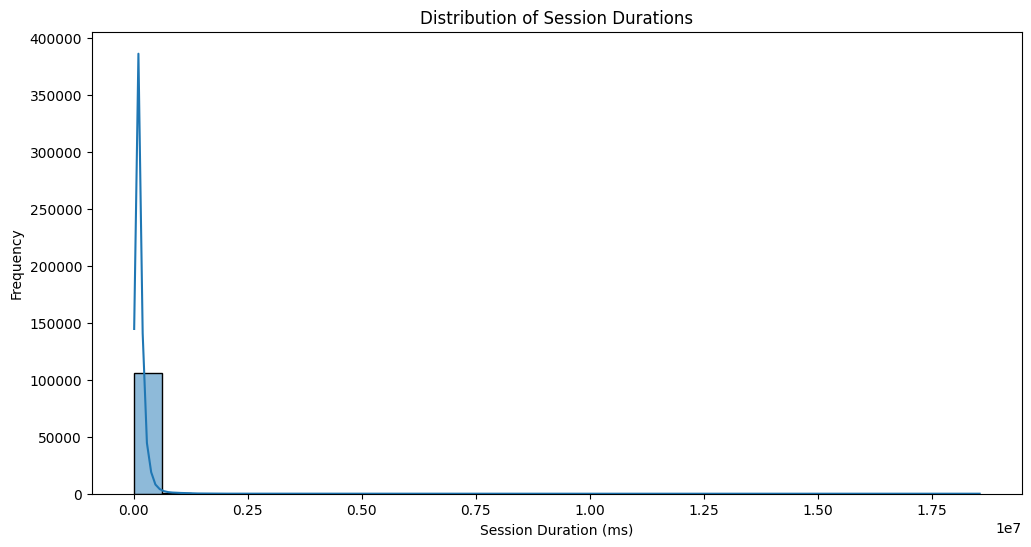

In [77]:
# Ensure the column name matches your DataFrame
plt.figure(figsize=(12, 6))
sns.histplot(user_aggregated_data['Dur. (ms)'], bins=30, kde=True)
plt.title('Distribution of Session Durations')
plt.xlabel('Session Duration (ms)')
plt.ylabel('Frequency')
plt.show()

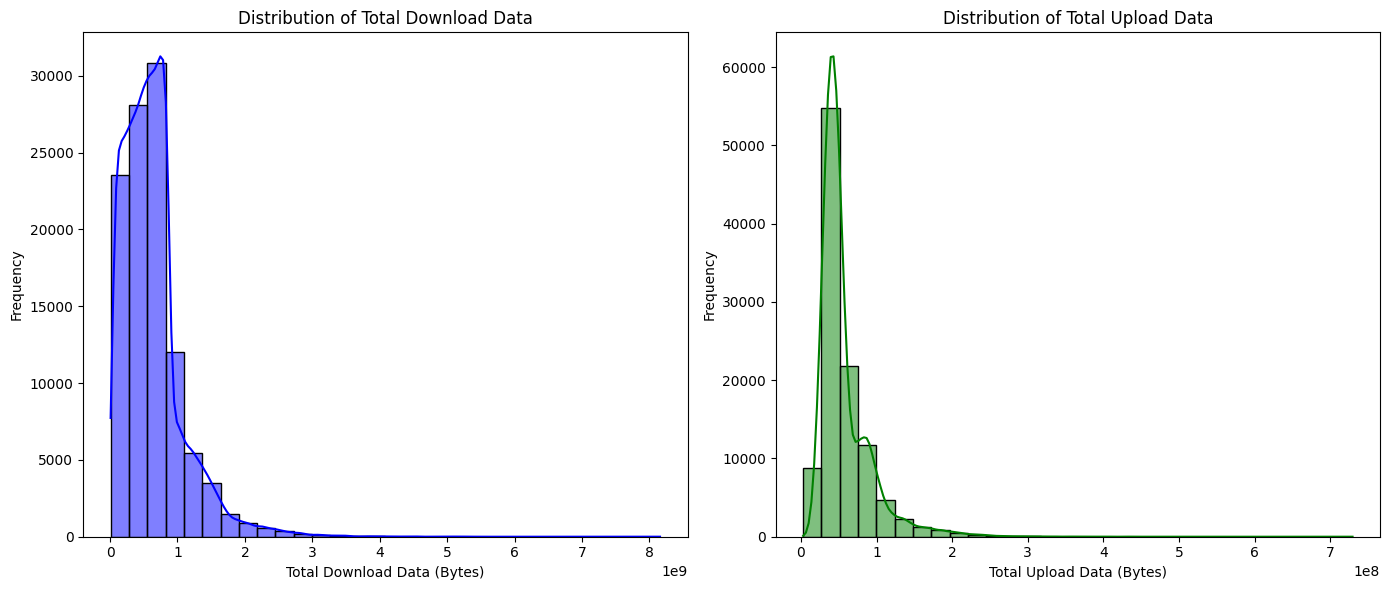

In [79]:
# Set up the figure and axes
plt.figure(figsize=(14, 6))

# Plot Total Download Data
plt.subplot(1, 2, 1)
sns.histplot(user_aggregated_data['Total DL (Bytes)'], bins=30, kde=True, color='blue')
plt.title('Distribution of Total Download Data')
plt.xlabel('Total Download Data (Bytes)')
plt.ylabel('Frequency')

# Plot Total Upload Data
plt.subplot(1, 2, 2)
sns.histplot(user_aggregated_data['Total UL (Bytes)'], bins=30, kde=True, color='green')
plt.title('Distribution of Total Upload Data')
plt.xlabel('Total Upload Data (Bytes)')
plt.ylabel('Frequency')

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()


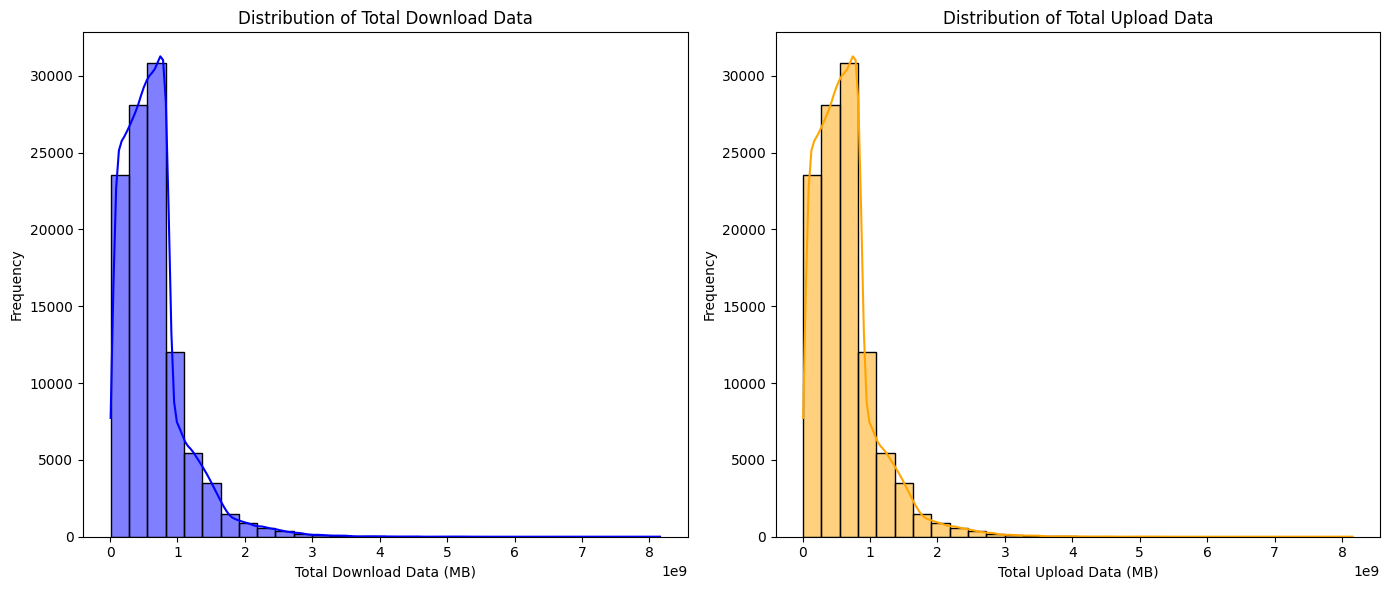

In [91]:
# Set up the figure and axes
plt.figure(figsize=(14, 6))

# Plot Total Download Data
plt.subplot(1, 2, 1)
sns.histplot(user_aggregated_data.get('Total DL (Bytes)', []), bins=30, kde=True, color='blue')
plt.title('Distribution of Total Download Data')
plt.xlabel('Total Download Data (MB)')
plt.ylabel('Frequency')

# Plot Total Upload Data
plt.subplot(1, 2, 2)
sns.histplot(user_aggregated_data.get('Total DL (Bytes)', []), bins=30, kde=True, color='orange')
plt.title('Distribution of Total Upload Data')
plt.xlabel('Total Upload Data (MB)')
plt.ylabel('Frequency')

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()


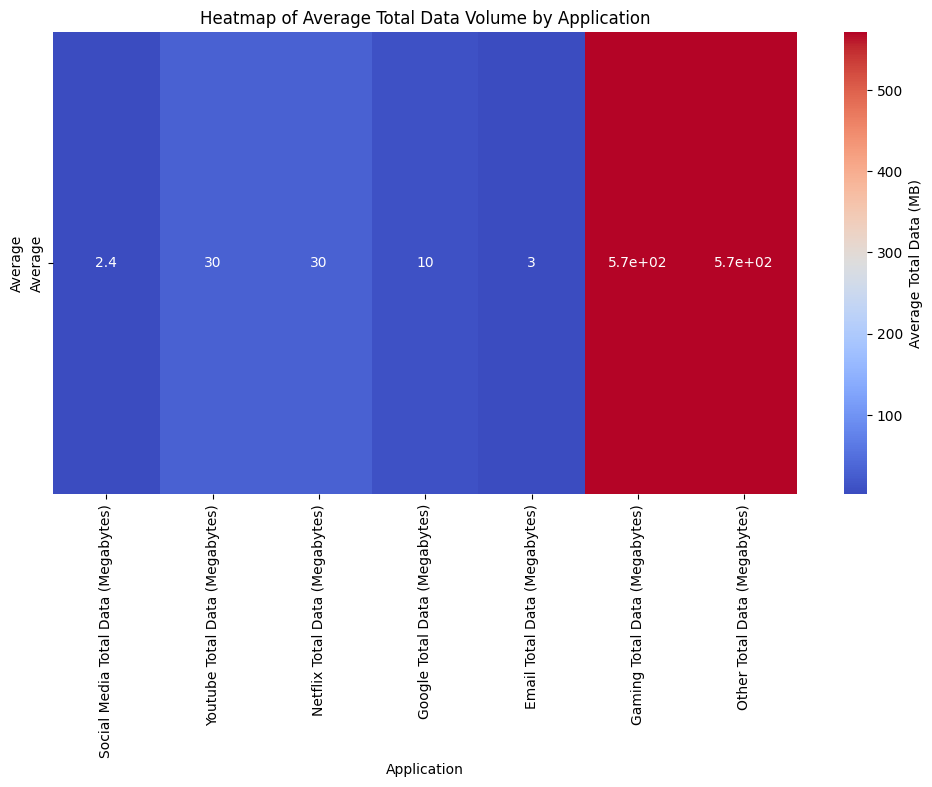

In [81]:
# Calculate the average total data volume for each application
heatmap_data = user_aggregated_data.filter(like='Total Data (Megabytes)').mean()

# Create the heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(
    heatmap_data.values.reshape(1, -1),
    annot=True,
    cmap='coolwarm',
    xticklabels=heatmap_data.index,
    yticklabels=['Average'],
    cbar_kws={'label': 'Average Total Data (MB)'}
)
plt.title('Heatmap of Average Total Data Volume by Application')
plt.xlabel('Application')
plt.ylabel('Average')
plt.show()

Text(0, 0.5, 'Frequency')

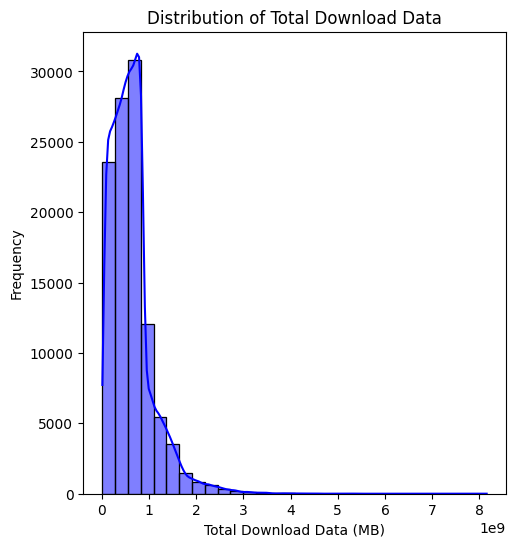

In [90]:
# Distribution of Total Data Download/Upload
plt.figure(figsize=(12, 6))

# Plot Total Download Data
plt.subplot(1, 2, 1)
sns.histplot(user_aggregated_data['Total DL (Bytes)'], bins=30, kde=True, color='blue')
plt.title('Distribution of Total Download Data')
plt.xlabel('Total Download Data (MB)')
plt.ylabel('Frequency')